<a href="https://colab.research.google.com/github/YagovkinaA/nnmycop/blob/main/try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.13.0+cu116'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://vk.com/doc141739129_655275534")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 1 directories and 0 images in 'data/pizza_steak_sushi'.
There are 2 directories and 0 images in 'data/pizza_steak_sushi/dataset'.
There are 25 directories and 1 images in 'data/pizza_steak_sushi/dataset/test'.
There are 0 directories and 80 images in 'data/pizza_steak_sushi/dataset/test/Baroque architecture'.
There are 0 directories and 80 images in 'data/pizza_steak_sushi/dataset/test/Tudor Revival architecture'.
There are 0 directories and 60 images in 'data/pizza_steak_sushi/dataset/test/American craftsman style'.
There are 0 directories and 60 images in 'data/pizza_steak_sushi/dataset/test/Georgian architecture'.
There are 0 directories and 60 images in 'data/pizza_steak_sushi/dataset/test/Romanesque architecture'.
There are 0 directories and 60 images in 'data/pizza_steak_sushi/dataset/test/Byzantine architecture'.
There are 0 directories and 80 images in 'data/pizza_steak_sushi/dataset/test/International style'.
There are 0 directories and 80 images in 'data/pizza_steak

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/dataset/train/Baroque architecture/4572_Sorbonnenice.jpg
Image class: Baroque architecture
Image height: 537
Image width: 434


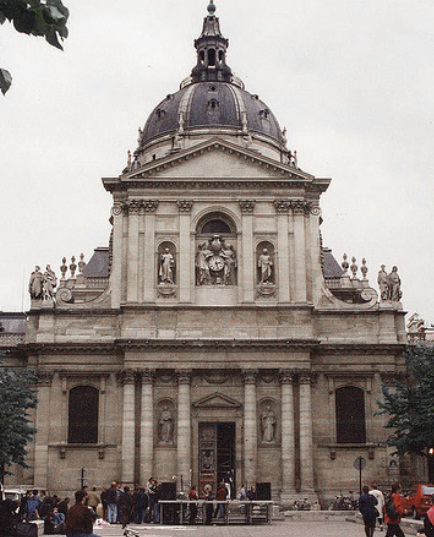

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

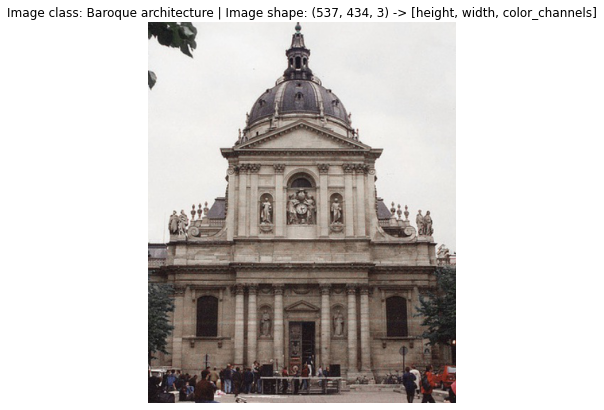

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

<ipython-input-13-7ae392008cd6>:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2)


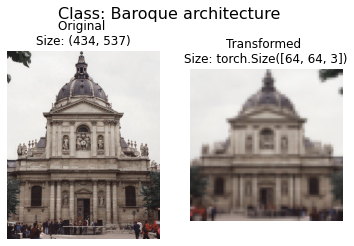

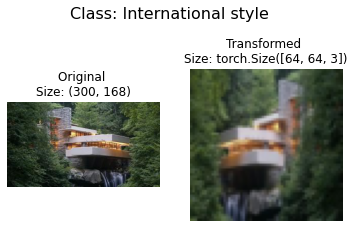

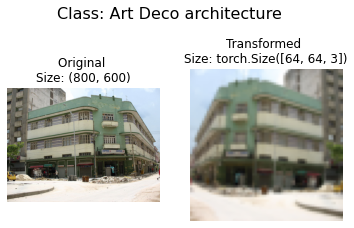

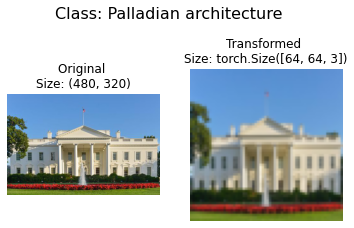

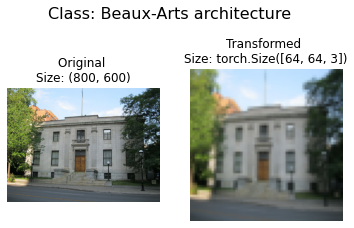

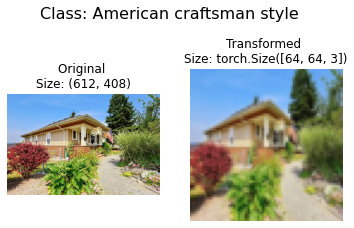

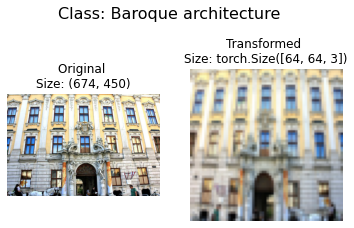

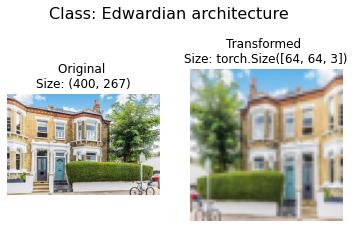

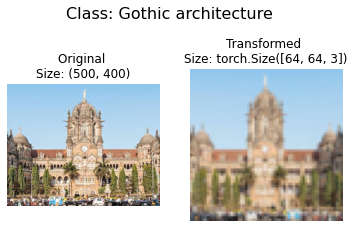

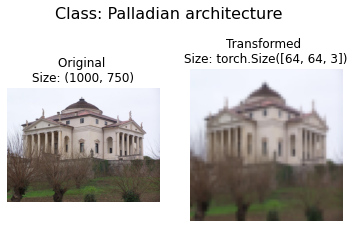

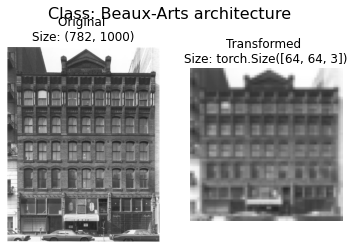

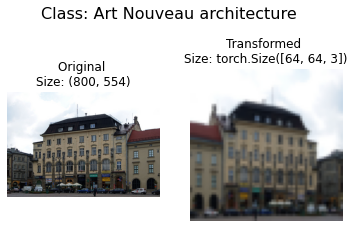

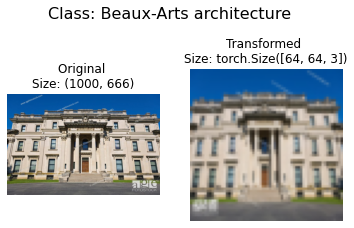

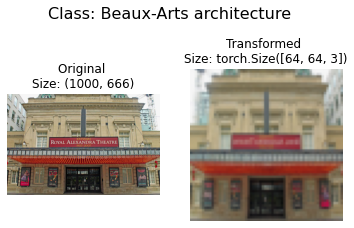

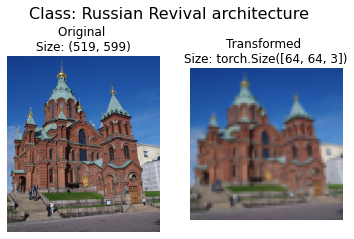

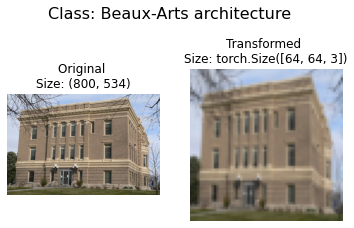

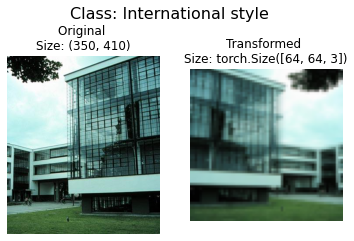

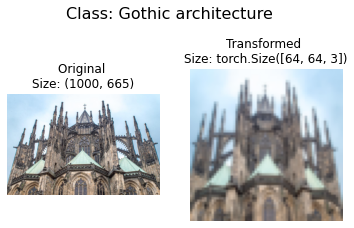

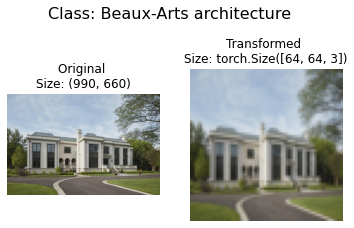

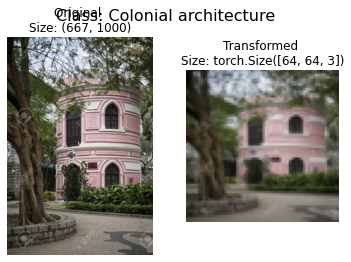

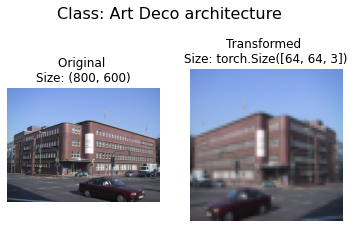

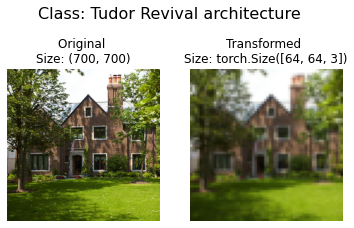

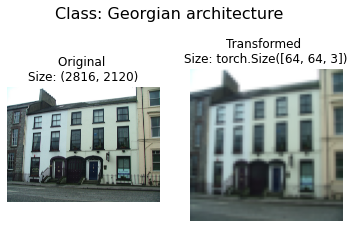

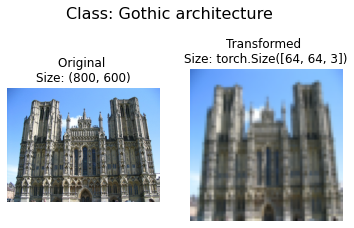

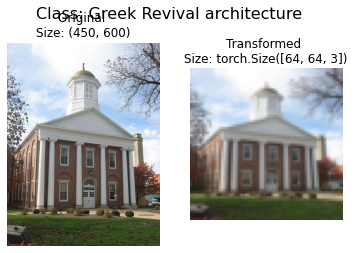

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=25)

In [15]:
print(train_dir)

data/pizza_steak_sushi/train


In [16]:
train_dir='data/pizza_steak_sushi/dataset/train'

In [17]:
test_dir='data/pizza_steak_sushi/dataset/test'

In [18]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8313
    Root location: data/pizza_steak_sushi/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1800
    Root location: data/pizza_steak_sushi/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [19]:
# Get class names as a list
class_names = train_data.classes
class_names

['Achaemenid architecture',
 'American Foursquare architecture',
 'American craftsman style',
 'Ancient Egyptian architecture',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'International style',
 'Novelty architecture',
 'Palladian architecture',
 'Postmodern architecture',
 'Queen Anne architecture',
 'Romanesque architecture',
 'Russian Revival architecture',
 'Tudor Revival architecture']

In [20]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Achaemenid architecture': 0,
 'American Foursquare architecture': 1,
 'American craftsman style': 2,
 'Ancient Egyptian architecture': 3,
 'Art Deco architecture': 4,
 'Art Nouveau architecture': 5,
 'Baroque architecture': 6,
 'Bauhaus architecture': 7,
 'Beaux-Arts architecture': 8,
 'Byzantine architecture': 9,
 'Chicago school architecture': 10,
 'Colonial architecture': 11,
 'Deconstructivism': 12,
 'Edwardian architecture': 13,
 'Georgian architecture': 14,
 'Gothic architecture': 15,
 'Greek Revival architecture': 16,
 'International style': 17,
 'Novelty architecture': 18,
 'Palladian architecture': 19,
 'Postmodern architecture': 20,
 'Queen Anne architecture': 21,
 'Romanesque architecture': 22,
 'Russian Revival architecture': 23,
 'Tudor Revival architecture': 24}

In [21]:
# Check the lengths
len(train_data), len(test_data)

(8313, 1800)

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.7529, 0.7490, 0.7412,  ..., 0.6039, 0.6078, 0.6157],
         [0.7529, 0.7490, 0.7451,  ..., 0.6000, 0.6078, 0.6157],
         [0.7569, 0.7529, 0.7490,  ..., 0.6000, 0.6078, 0.6118],
         ...,
         [0.8824, 0.8706, 0.8588,  ..., 0.8392, 0.8392, 0.8235],
         [0.8863, 0.8784, 0.8627,  ..., 0.8431, 0.8471, 0.8471],
         [0.8392, 0.8275, 0.8353,  ..., 0.8627, 0.8667, 0.8745]],

        [[0.8157, 0.8118, 0.8118,  ..., 0.6863, 0.6902, 0.6980],
         [0.8157, 0.8118, 0.8118,  ..., 0.6824, 0.6902, 0.6980],
         [0.8196, 0.8157, 0.8118,  ..., 0.6863, 0.6863, 0.6941],
         ...,
         [0.7294, 0.7333, 0.7373,  ..., 0.7608, 0.7608, 0.7490],
         [0.7333, 0.7333, 0.7333,  ..., 0.7451, 0.7529, 0.7529],
         [0.7373, 0.7294, 0.7451,  ..., 0.7412, 0.7451, 0.7529]],

        [[0.8706, 0.8706, 0.8667,  ..., 0.7922, 0.7961, 0.7961],
         [0.8706, 0.8706, 0.8706,  ..., 0.7882, 0.7961, 0.7961],
         [0.8706, 0.8667, 0.8706,  ..., 0.78

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


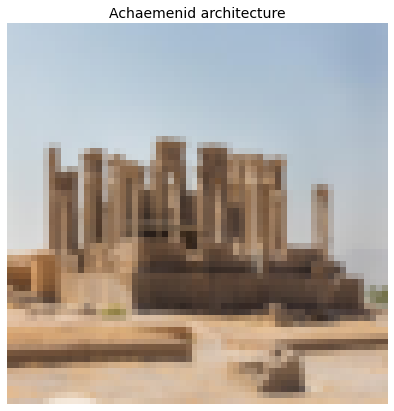

In [23]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [24]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff50f6f4d00>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff50f6f4cd0>)

In [25]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [26]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [27]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['Achaemenid architecture',
  'American Foursquare architecture',
  'American craftsman style',
  'Ancient Egyptian architecture',
  'Art Deco architecture',
  'Art Nouveau architecture',
  'Baroque architecture',
  'Bauhaus architecture',
  'Beaux-Arts architecture',
  'Byzantine architecture',
  'Chicago school architecture',
  'Colonial architecture',
  'Deconstructivism',
  'Edwardian architecture',
  'Georgian architecture',
  'Gothic architecture',
  'Greek Revival architecture',
  'International style',
  'Novelty architecture',
  'Palladian architecture',
  'Postmodern architecture',
  'Queen Anne architecture',
  'Romanesque architecture',
  'Russian Revival architecture',
  'Tudor Revival architecture'],
 {'Achaemenid architecture': 0,
  'American Foursquare architecture': 1,
  'American craftsman style': 2,
  'Ancient Egyptian architecture': 3,
  'Art Deco architecture': 4,
  'Art Nouveau architecture': 5,
  'Baroque architecture': 6,
  'Bauhaus architecture': 7,
  'Beaux-A

In [29]:
image_path='data/pizza_steak_sushi/dataset/train'

In [31]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path ))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/dataset/train
Class names found: ['.DS_Store', 'Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


In [32]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [33]:
find_classes(train_dir)

(['Achaemenid architecture',
  'American Foursquare architecture',
  'American craftsman style',
  'Ancient Egyptian architecture',
  'Art Deco architecture',
  'Art Nouveau architecture',
  'Baroque architecture',
  'Bauhaus architecture',
  'Beaux-Arts architecture',
  'Byzantine architecture',
  'Chicago school architecture',
  'Colonial architecture',
  'Deconstructivism',
  'Edwardian architecture',
  'Georgian architecture',
  'Gothic architecture',
  'Greek Revival architecture',
  'International style',
  'Novelty architecture',
  'Palladian architecture',
  'Postmodern architecture',
  'Queen Anne architecture',
  'Romanesque architecture',
  'Russian Revival architecture',
  'Tudor Revival architecture'],
 {'Achaemenid architecture': 0,
  'American Foursquare architecture': 1,
  'American craftsman style': 2,
  'Ancient Egyptian architecture': 3,
  'Art Deco architecture': 4,
  'Art Nouveau architecture': 5,
  'Baroque architecture': 6,
  'Bauhaus architecture': 7,
  'Beaux-A

In [34]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [35]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [36]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ff50f692d90>,
 <__main__.ImageFolderCustom at 0x7ff50f692f40>)

In [37]:
len(train_data_custom), len(test_data_custom)

(7270, 1577)

In [38]:
train_data_custom.classes

['Achaemenid architecture',
 'American Foursquare architecture',
 'American craftsman style',
 'Ancient Egyptian architecture',
 'Art Deco architecture',
 'Art Nouveau architecture',
 'Baroque architecture',
 'Bauhaus architecture',
 'Beaux-Arts architecture',
 'Byzantine architecture',
 'Chicago school architecture',
 'Colonial architecture',
 'Deconstructivism',
 'Edwardian architecture',
 'Georgian architecture',
 'Gothic architecture',
 'Greek Revival architecture',
 'International style',
 'Novelty architecture',
 'Palladian architecture',
 'Postmodern architecture',
 'Queen Anne architecture',
 'Romanesque architecture',
 'Russian Revival architecture',
 'Tudor Revival architecture']

In [39]:
train_data_custom.class_to_idx

{'Achaemenid architecture': 0,
 'American Foursquare architecture': 1,
 'American craftsman style': 2,
 'Ancient Egyptian architecture': 3,
 'Art Deco architecture': 4,
 'Art Nouveau architecture': 5,
 'Baroque architecture': 6,
 'Bauhaus architecture': 7,
 'Beaux-Arts architecture': 8,
 'Byzantine architecture': 9,
 'Chicago school architecture': 10,
 'Colonial architecture': 11,
 'Deconstructivism': 12,
 'Edwardian architecture': 13,
 'Georgian architecture': 14,
 'Gothic architecture': 15,
 'Greek Revival architecture': 16,
 'International style': 17,
 'Novelty architecture': 18,
 'Palladian architecture': 19,
 'Postmodern architecture': 20,
 'Queen Anne architecture': 21,
 'Romanesque architecture': 22,
 'Russian Revival architecture': 23,
 'Tudor Revival architecture': 24}

In [40]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

False
True
True


In [41]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

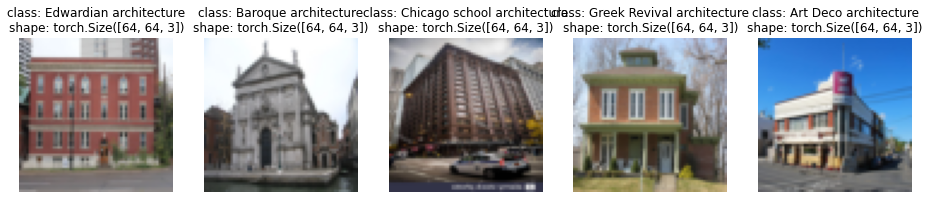

In [42]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


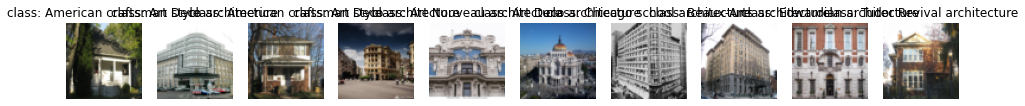

In [43]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

In [44]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ff50e8679a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff50e867d00>)

In [45]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [46]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [53]:
image_path = data_path / "pizza_steak_sushi/dataset"

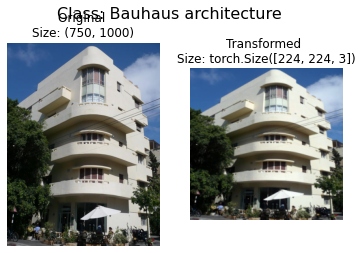

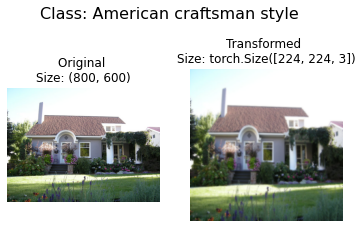

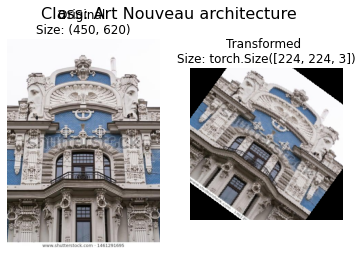

In [54]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [55]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [56]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7ff52d9b3f70>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff50e8678e0>)

In [57]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=25, bias=True)
  )
)

In [58]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0712,  0.0561,  0.0353, -0.0238, -0.0226,  0.0416, -0.0760,  0.0868,
         -0.0112,  0.0417, -0.0444, -0.0367,  0.0040, -0.0488,  0.0695,  0.0162,
         -0.0119,  0.0596,  0.0114,  0.0673, -0.0176, -0.0188,  0.0344,  0.0078,
          0.0278]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0424, 0.0417, 0.0409, 0.0385, 0.0386, 0.0411, 0.0366, 0.0430, 0.0390,
         0.0411, 0.0377, 0.0380, 0.0396, 0.0376, 0.0423, 0.0401, 0.0390, 0.0419,
         0.0399, 0.0422, 0.0388, 0.0387, 0.0408, 0.0398, 0.0406]],
       device='cuda:0')

Output prediction label:
tensor([7], device='cuda:0')

Actual label:
15


In [59]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 25]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [60]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [61]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [62]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [63]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1899 | train_acc: 0.0672 | test_loss: 3.1158 | test_acc: 0.0943
Epoch: 2 | train_loss: 3.0023 | train_acc: 0.1304 | test_loss: 2.8804 | test_acc: 0.1606
Epoch: 3 | train_loss: 2.7829 | train_acc: 0.1860 | test_loss: 2.7728 | test_acc: 0.1782
Epoch: 4 | train_loss: 2.5593 | train_acc: 0.2546 | test_loss: 2.6623 | test_acc: 0.2138
Epoch: 5 | train_loss: 2.3677 | train_acc: 0.3058 | test_loss: 2.5952 | test_acc: 0.2330
Total training time: 393.127 seconds


In [64]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [65]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

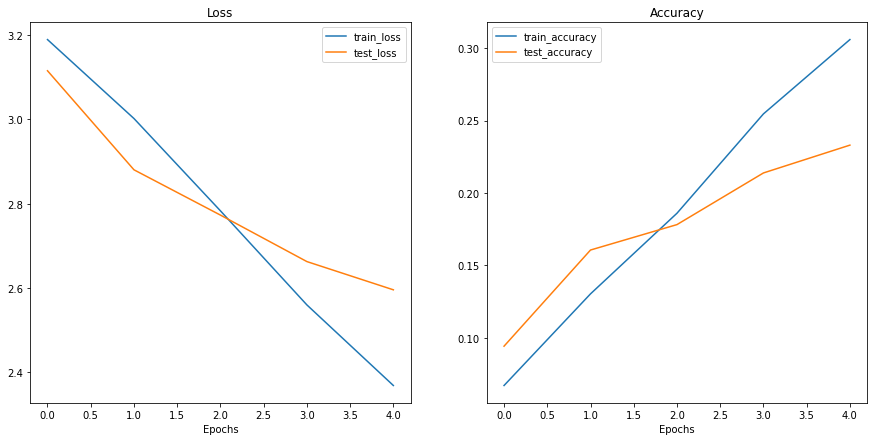

In [66]:
plot_loss_curves(model_0_results)


In [67]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [68]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 8313
     Root location: data/pizza_steak_sushi/dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 1800
     Root location: data/pizza_steak_sushi/dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [69]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff52092d670>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff50f6f4cd0>)

In [70]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=25, bias=True)
  )
)

In [71]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.1880 | train_acc: 0.0683 | test_loss: 3.1041 | test_acc: 0.0833
Epoch: 2 | train_loss: 3.0736 | train_acc: 0.0986 | test_loss: 2.9010 | test_acc: 0.1486
Epoch: 3 | train_loss: 2.9655 | train_acc: 0.1303 | test_loss: 2.7802 | test_acc: 0.1678
Epoch: 4 | train_loss: 2.8838 | train_acc: 0.1533 | test_loss: 2.7301 | test_acc: 0.1941
Epoch: 5 | train_loss: 2.8173 | train_acc: 0.1762 | test_loss: 2.6904 | test_acc: 0.2094
Total training time: 401.062 seconds


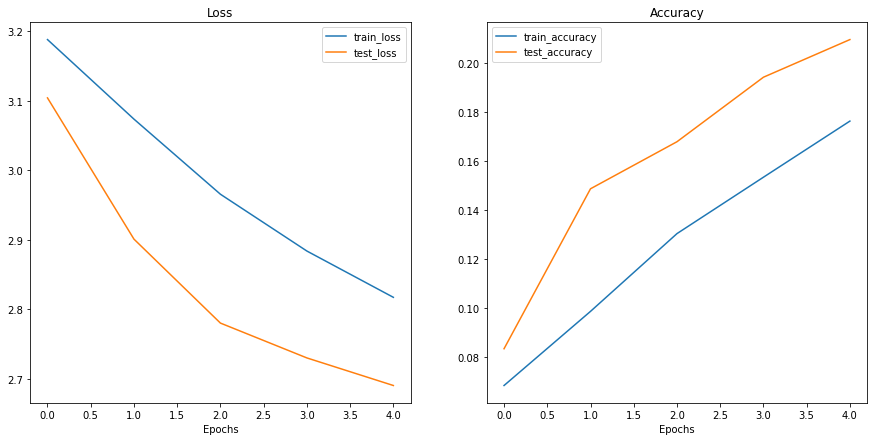

In [72]:
plot_loss_curves(model_1_results)

In [73]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0    3.189899   0.067168   3.115809  0.094298
1    3.002261   0.130389   2.880404  0.160636
2    2.782910   0.186019   2.772753  0.178180
3    2.559274   0.254563   2.662256  0.213816
4    2.367729   0.305832   2.595159  0.233004

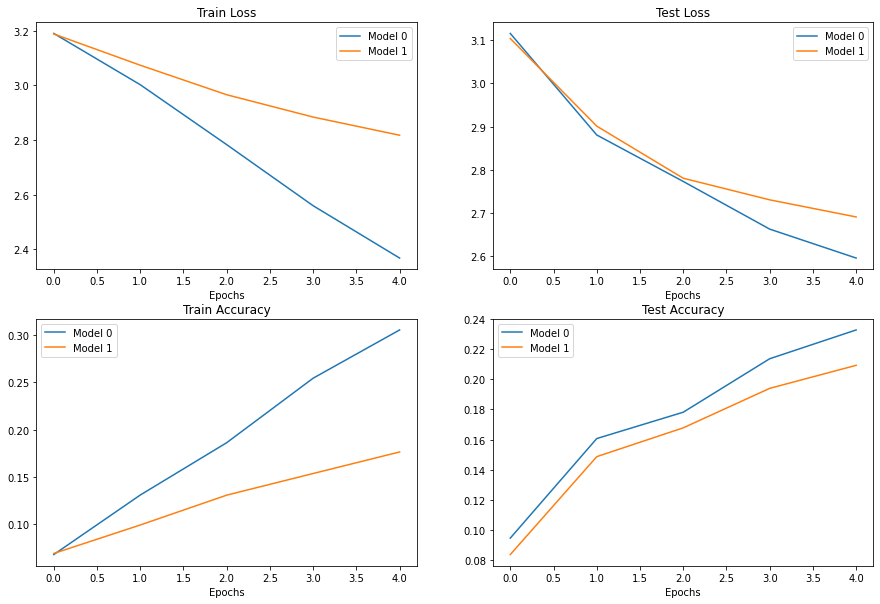

In [74]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [123]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "chram.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/YagovkinaA/nnmycop/main/cvEkaterina.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [124]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

In [125]:
custom_image_uint8

tensor([[[221, 220, 220,  ...,  38,  44,  74],
         [220, 220, 220,  ...,  31,  28,  53],
         [219, 220, 221,  ...,  26,  15,  43],
         ...,
         [111, 108, 100,  ...,  76,  75,  83],
         [111, 113, 111,  ...,  78,  77,  84],
         [114, 114, 113,  ...,  77,  77,  84]],

        [[231, 230, 230,  ...,  54,  60,  90],
         [230, 230, 230,  ...,  47,  44,  69],
         [229, 230, 231,  ...,  39,  28,  56],
         ...,
         [104, 101,  93,  ...,  68,  67,  75],
         [104, 106, 104,  ...,  69,  68,  75],
         [107, 107, 106,  ...,  68,  68,  75]],

        [[243, 242, 242,  ...,  43,  47,  77],
         [242, 242, 242,  ...,  36,  31,  56],
         [241, 242, 243,  ...,  29,  18,  46],
         ...,
         [ 96,  93,  83,  ...,  66,  65,  73],
         [ 96,  98,  94,  ...,  70,  69,  76],
         [ 99,  99,  96,  ...,  69,  69,  76]]], dtype=torch.uint8)

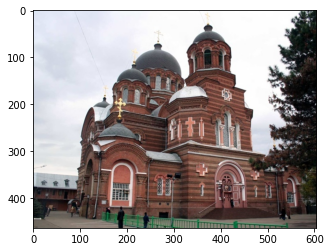

In [126]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [127]:
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[221, 220, 220,  ...,  38,  44,  74],
         [220, 220, 220,  ...,  31,  28,  53],
         [219, 220, 221,  ...,  26,  15,  43],
         ...,
         [111, 108, 100,  ...,  76,  75,  83],
         [111, 113, 111,  ...,  78,  77,  84],
         [114, 114, 113,  ...,  77,  77,  84]],

        [[231, 230, 230,  ...,  54,  60,  90],
         [230, 230, 230,  ...,  47,  44,  69],
         [229, 230, 231,  ...,  39,  28,  56],
         ...,
         [104, 101,  93,  ...,  68,  67,  75],
         [104, 106, 104,  ...,  69,  68,  75],
         [107, 107, 106,  ...,  68,  68,  75]],

        [[243, 242, 242,  ...,  43,  47,  77],
         [242, 242, 242,  ...,  36,  31,  56],
         [241, 242, 243,  ...,  29,  18,  46],
         ...,
         [ 96,  93,  83,  ...,  66,  65,  73],
         [ 96,  98,  94,  ...,  70,  69,  76],
         [ 99,  99,  96,  ...,  69,  69,  76]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 464, 604])

Custom image dtype

In [129]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

In [130]:
custom_image = custom_image / 255. 

In [131]:
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.8667, 0.8627, 0.8627,  ..., 0.1490, 0.1725, 0.2902],
         [0.8627, 0.8627, 0.8627,  ..., 0.1216, 0.1098, 0.2078],
         [0.8588, 0.8627, 0.8667,  ..., 0.1020, 0.0588, 0.1686],
         ...,
         [0.4353, 0.4235, 0.3922,  ..., 0.2980, 0.2941, 0.3255],
         [0.4353, 0.4431, 0.4353,  ..., 0.3059, 0.3020, 0.3294],
         [0.4471, 0.4471, 0.4431,  ..., 0.3020, 0.3020, 0.3294]],

        [[0.9059, 0.9020, 0.9020,  ..., 0.2118, 0.2353, 0.3529],
         [0.9020, 0.9020, 0.9020,  ..., 0.1843, 0.1725, 0.2706],
         [0.8980, 0.9020, 0.9059,  ..., 0.1529, 0.1098, 0.2196],
         ...,
         [0.4078, 0.3961, 0.3647,  ..., 0.2667, 0.2627, 0.2941],
         [0.4078, 0.4157, 0.4078,  ..., 0.2706, 0.2667, 0.2941],
         [0.4196, 0.4196, 0.4157,  ..., 0.2667, 0.2667, 0.2941]],

        [[0.9529, 0.9490, 0.9490,  ..., 0.1686, 0.1843, 0.3020],
         [0.9490, 0.9490, 0.9490,  ..., 0.1412, 0.1216, 0.2196],
         [0.9451, 0.9490, 0.9529,  ..

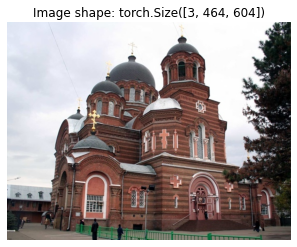

In [132]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [133]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 464, 604])
New shape: torch.Size([3, 64, 64])


In [136]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [137]:
custom_image_pred

tensor([[-2.7711, -1.8957, -0.8546, -3.5678, -0.3480,  0.2050,  0.2086,  0.0364,
          0.2549, -0.2959, -1.6951, -0.6427, -1.2613, -0.8966, -1.1774, -1.4384,
          0.0039, -0.2912, -1.0061, -0.7688, -0.7873,  0.6948, -0.7720,  0.2474,
         -1.1770]], device='cuda:0')

In [138]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-2.7711, -1.8957, -0.8546, -3.5678, -0.3480,  0.2050,  0.2086,  0.0364,
          0.2549, -0.2959, -1.6951, -0.6427, -1.2613, -0.8966, -1.1774, -1.4384,
          0.0039, -0.2912, -1.0061, -0.7688, -0.7873,  0.6948, -0.7720,  0.2474,
         -1.1770]], device='cuda:0')
Prediction probabilities: tensor([[0.0039, 0.0094, 0.0267, 0.0018, 0.0443, 0.0770, 0.0773, 0.0651, 0.0810,
         0.0467, 0.0115, 0.0330, 0.0178, 0.0256, 0.0193, 0.0149, 0.0630, 0.0469,
         0.0229, 0.0291, 0.0285, 0.1257, 0.0290, 0.0803, 0.0193]],
       device='cuda:0')
Prediction label: tensor([21], device='cuda:0')


In [139]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'Queen Anne architecture'